#### 【 이미지와 마스크(Mask) 】

- 특정 연산을 어디에 / 얼마나 / 어떻게 적용할지 결정하는 제어용 배열(matrix)
    * 이 픽셀은 처리한다 / 안 한다
    * 이 픽셀은 강하게 / 약하게 처리한다
- 목적
    * Filtering : mask는 주변 픽셀의 가중치 집합
    * 영역 선택 (ROI) : 특정 영역만 처리, 얼굴만 블러, 배경만 제거
    * 연산 제한 / 제어 : 연산 범위 제한, 특정 픽셀 무시, 조건부 연산 등
    * 객체 분할 (Segmentation) : 배경, 사람, 자동차 등 
    * 합성(Compositing) : 이미지 합성, 블렌딩

- 형태
    * Binary Mask : 가장 일반적인 형태
        + 0 → 처리 안 함/1 → 처리 함
        + ROI(관심영역) 지정/객체 분리/배경 제거

    * Weighted Mask
        + 0~1 또는 실수값
        + 픽셀 영향도 조절/ 부드러운 연산 /Filtering에 많이 사용됨

    * Kernel / Filter Mask
        + Filtering에서 사용하는 컨볼루션 마스크
        + 평균 필터, Sobel
- 용어 이해
    * Kernel  : 연산 규칙(숫자 행렬, 수학적 정의). 주변 픽셀을 어떻게 조합할지 정의한 숫자 행렬
    * Filter  : Kernel을 사용한 처리 "행위"
    * Mask    : 연산을 어디에/얼마나 적용할지 정하는 "제어 정보"

[1] 모듈 로딩 및 사용자 함수 정의 <hr>

In [64]:
## [1-1] 모듈로딩
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [65]:
## [1-2] 사용자 정의 함수 
## -----------------------------------------------
## 함수이름 : show
## 매개변수 : title  창 제목
##           img    출력 이미지 데이터
##           cmap   컬러맵
## 반환결과 : 없음
## -----------------------------------------------
def show(nrow, ncol, titles, imgNPs, flag=None, cmap=None):
    fig, axes   = plt.subplots(nrow, ncol, figsize=(20,5))
    if nrow!=1: axes = axes.flatten()
    if nrow*ncol == 1 : axes = [axes]
    for ax, img, title in zip(axes, imgNPs, titles):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cmap=cmap)
        ax.set_title(title)
    plt.show()


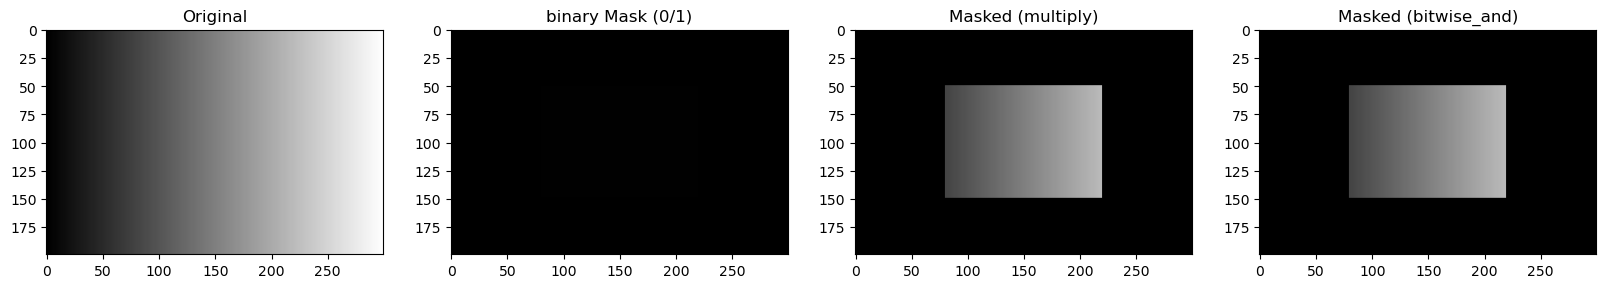

In [66]:
## -----------------------------------------------
## [1-3] 실습 이미지 준비
## -----------------------------------------------
## 1) 테스트 이미지 만들기 (그라데이션)
h, w = 200, 300
img  = np.tile(np.linspace(0, 255, w, dtype=np.uint8), (h, 1))  

## 2) Binary mask 만들기 (가운데 사각형만 1)
mask = np.zeros((h, w), dtype=np.uint8)
mask[50:150, 80:220] = 1  # 1이면 통과, 0이면 제거

## 3) mask 적용 (방법 A: 곱셈)
maskedA = (img * mask).astype(np.uint8)

## 4) mask 적용 (방법 B: cv2.bitwise_and)
mask255 = (mask * 255).astype(np.uint8)
maskedB = cv2.bitwise_and(img, img, mask=mask255)

## 5) 시각화 비교 
titles = ['Original', 'binary Mask (0/1)', 'Masked (multiply)', 'Masked (bitwise_and)']
imgNPs = [img, mask, maskedA, maskedB]
show(1, 4, titles, imgNPs, 'gray')

[3] Weighted Mask(Soft Mask / 알파 블렌딩)<hr>
- 목적: 부드럽게 합성(경계가 자연스럽게)
- 딥러닝에서 말하는 soft mask

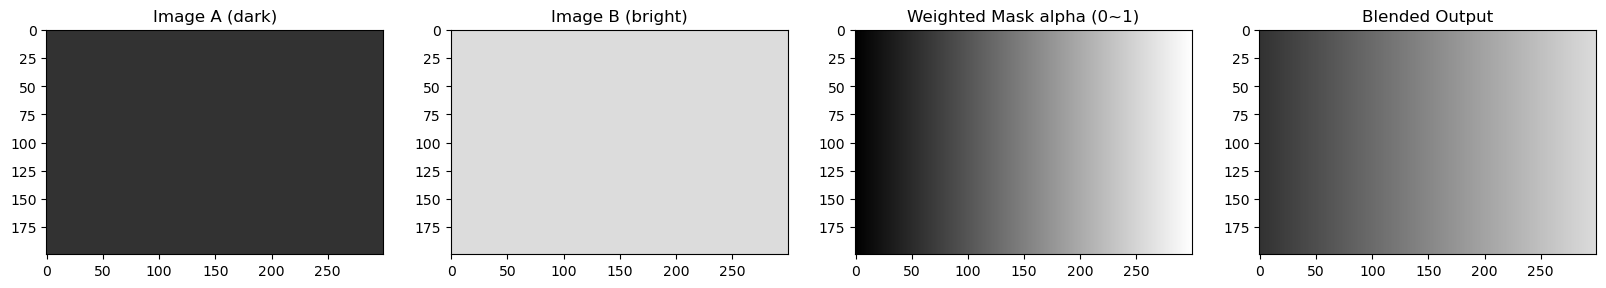

In [67]:
## 1) 두 이미지 만들기
h, w = 200, 300
A = np.full((h, w), 50, dtype=np.uint8)   # 어두운 배경
B = np.full((h, w), 220, dtype=np.uint8)  # 밝은 배경

## 2) weighted mask 만들기 (왼쪽 0 -> 오른쪽 1로 서서히 증가)
alpha = np.tile(np.linspace(0, 1, w, dtype=np.float32), (h, 1))  # (h,w) float

## 3) 알파 블렌딩: output = A*(1-alpha) + B*alpha
out = (A * (1 - alpha) + B * alpha).astype(np.uint8)

## 4) 시각화 비교 
titles = ['Image A (dark)', 'Image B (bright)', 'Weighted Mask alpha (0~1)', 'Blended Output']
imgNPs = [A, B, alpha, out]
show(1, 4, titles, imgNPs, 'gray')

[4] Kernel / Filter Mask 예제 (컨볼루션 마스크)<hr>
- 목적: Filtering(블러/샤픈/엣지)
- ROI 선택 아니라 **주변 픽셀을 섞는 규칙(가중치) 설정**
    - 커널: 연산 규칙
    - 필터: 커널을 적용하는 과정
    - 마스크: 연산을 적용할 범위나 강도 제어

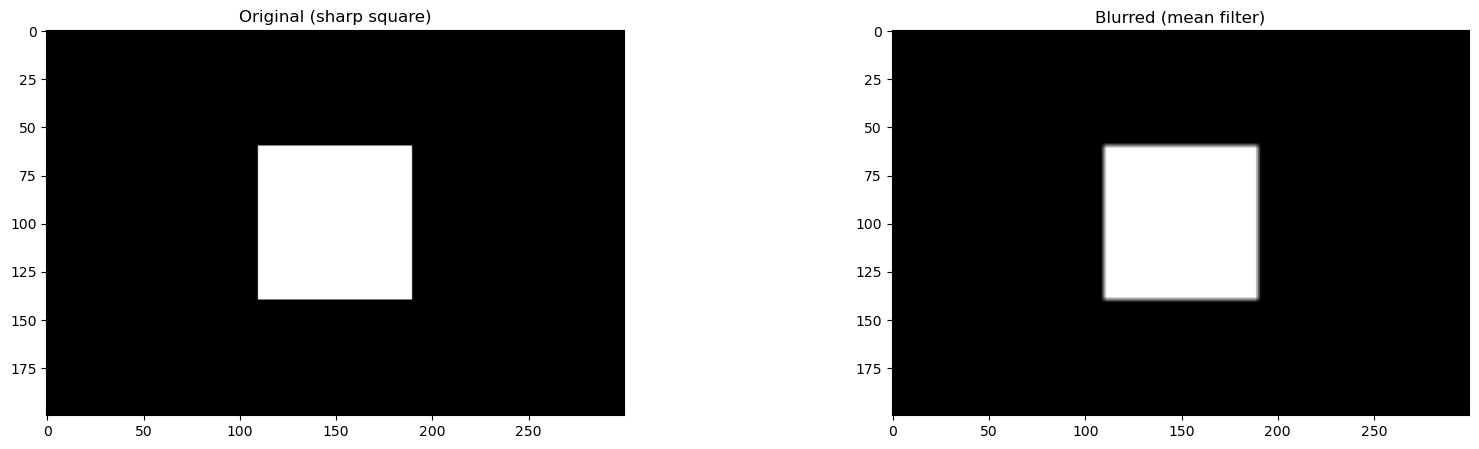

In [68]:
## ========================================
## [4-1] 평균 블러(Mean filter)
## ========================================
## 1) 테스트 이미지: 검은 바탕에 흰 사각형
img = np.zeros((200, 300), dtype=np.uint8)
img[60:140, 110:190] = 255


## 2) 평균 블러 커널(3x3)
kernel_mean = np.ones((3,3), dtype=np.float32) / 9.0
blur = cv2.filter2D(img, -1, kernel_mean)


## 3) 시각화 비교 
titles = ['Original (sharp square)', 'Blurred (mean filter)']
imgNPs = [img, blur]
show(1, 2, titles, imgNPs, 'gray')


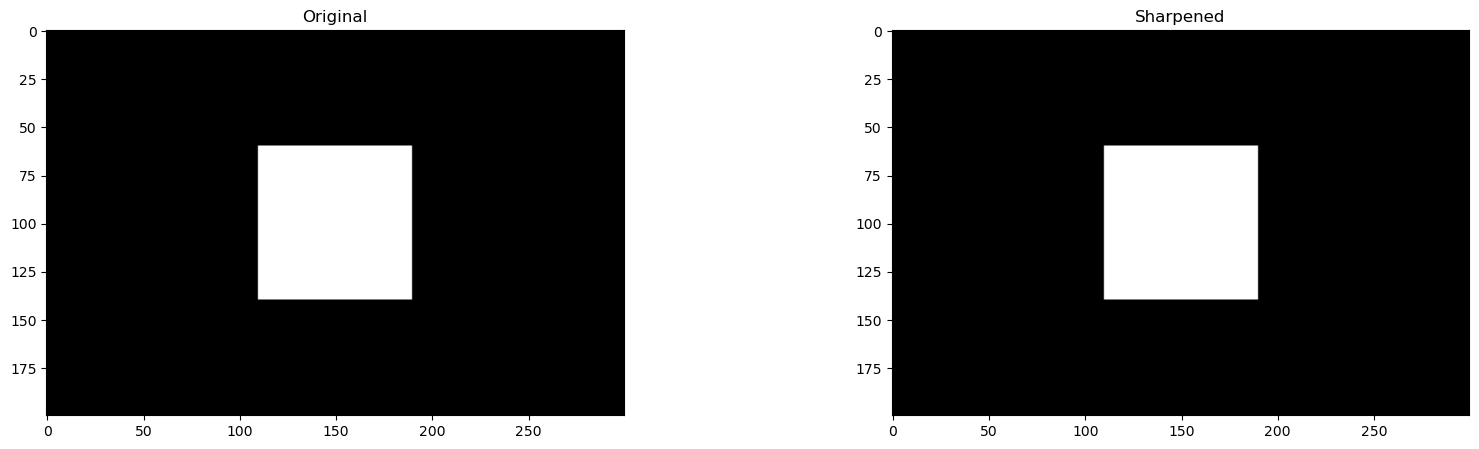

In [69]:
## ========================================
## [4-2] 샤픈(Sharpen) 
## ========================================
kernel_sharp = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

sharp = cv2.filter2D(img, -1, kernel_sharp)


## 3) 시각화 비교 
titles = ['Original', 'Sharpened']
imgNPs = [img, sharp]
show(1, 2, titles, imgNPs, 'gray')

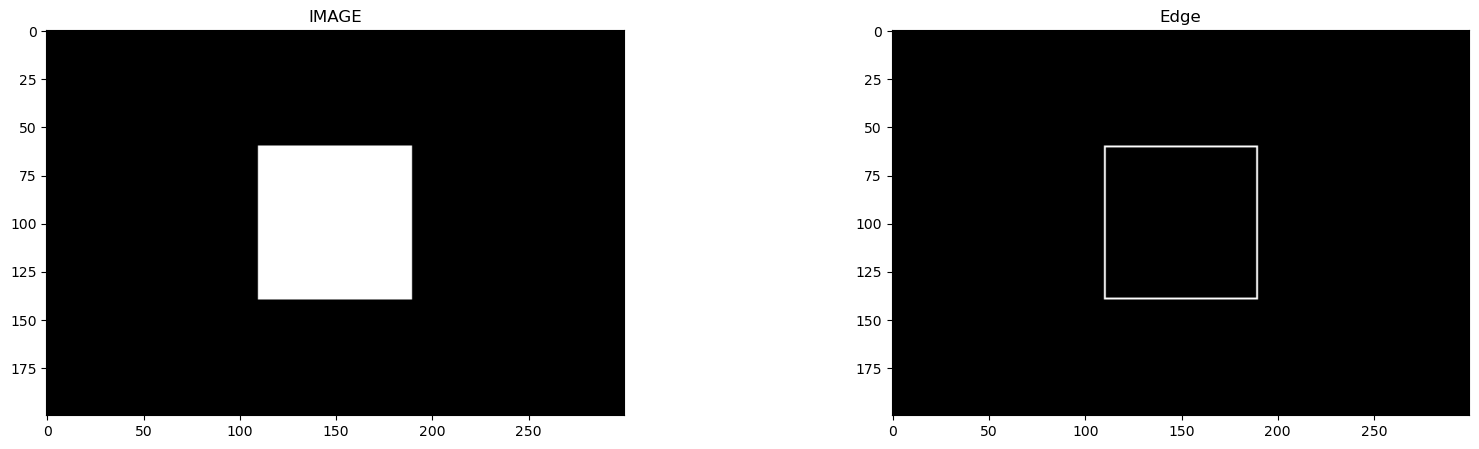

In [70]:
## ========================================
## [4-3] 엣지 검출(Edge)
## ========================================
kernel_edge = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
], dtype=np.float32)

edge = cv2.filter2D(img, -1, kernel_edge)

## 3) 시각화 비교 
titles = ['IMAGE', 'Edge']
imgNPs = [img, edge]
show(1, 2, titles, imgNPs, 'gray')

In [71]:
# 이미지 읽기
img = cv2.imread('../Data/Image/girl.jpg')

# 마스크 만들기
mask = np.zeros_like(img)
cv2.circle(mask, (150,140), 100, (255,255,255), -1)
#cv2.circle(대상이미지, (원점x, 원점y), 반지름, (색상), 채우기)

# 마스킹
masked = cv2.bitwise_and(img, mask)

# 결과 출력
cv2.imshow('original', img)
cv2.imshow('mask', mask)
cv2.imshow('masked', masked)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
# 설정
IMAGE_FILE = '../Data/Image/flower_rainbow.jpg'

## 이미지 데이터 로딩
img_bgr = cv2.imread(IMAGE_FILE)
print("이미지 데이터 OK!" if not None else "이미지 데이터 없음")

# 원본과 동일한 크기 마스크 생성
mask = np.zeros(img_bgr.shape[:2], dtype="uint8")

# 원 모양 마스크 (중앙 원 부분만 흰색)
cv2.circle(mask, (250, 250), 100, 255, -1)

# 마스크 적용
# -> 2개 이미지를 픽셀 단위로 AND 연산
# -> 마스크에서 지정한 영역만 원본 이미지를 살려두고 나머지는 지우기
masked = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)


이미지 데이터 OK!


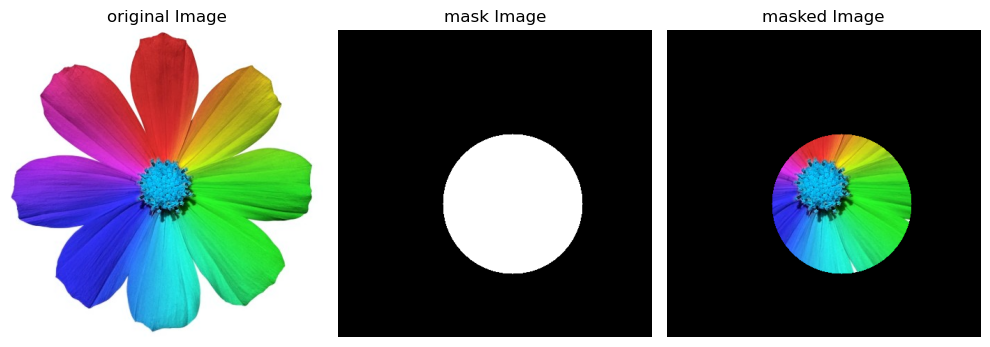

In [73]:
# 원본/마스크/마스크적용 이미지 출력해서 비교
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes = axes.flatten()
titles = ['original Image', 'mask Image', 'masked Image']
images = [img_bgr, mask, masked]

for idx, ax, title, img_data in zip(range(1,4), axes, titles, images):
    ax.imshow(img_data, cmap='gray' if idx==2 else 'viridis' )
    ax.set_title(title)
    ax.axis("off")
plt.tight_layout()
plt.show()